# Quantum signal processing for simulating quantum time evolution

References:
- John M. Martyn, Zane M. Rossi, Andrew K. Tan, Isaac L. Chuang  
  Grand unification of quantum algorithms  
  [PRX Quantum 2, 040203 (2021)](https://doi.org/10.1103/PRXQuantum.2.040203)

In [1]:
import numpy as np
from scipy.linalg import sqrtm, cosm, sinm, expm
import matplotlib.pyplot as plt

In [2]:
import qib

## Quantum signal processing circuit

In [3]:
def S(phi: float, q: qib.field.Qubit):
    """
    Construct the "signal-processing rotation operator".
    """
    return qib.RzGate(-2*phi, q)

In [4]:
def W(a: float, q: qib.field.Qubit):
    """
    Construct the "signal rotation operator".
    """
    return qib.RxGate(-2*np.arccos(a), q)

In [5]:
def qsp_circuit(V, phi_list, qaux):
    """
    Construct the quantum signal processing circuit.
    """
    assert len(phi_list) > 0
    circuit = qib.Circuit()
    circuit.append_gate(S(phi_list[0], qaux))
    for phi in phi_list[1:]:
        circuit.append_gate(V)
        circuit.append_gate(S(phi, qaux))
    return circuit

## Construct Hamiltonian and block-encoding gate

In [6]:
L = 5
latt = qib.lattice.IntegerLattice((L,), pbc=True)
field_hamil = qib.field.Field(qib.field.ParticleType.QUBIT, latt)

In [7]:
# Heisenberg-type Hamiltonian with random parameters
rng = np.random.default_rng(42)
H = qib.operator.HeisenbergHamiltonian(field_hamil, rng.standard_normal(size=3), rng.standard_normal(size=3))

# rescale parameters (effectively rescales overall Hamiltonian)
scale = 1.25 * np.linalg.norm(H.as_matrix().toarray(), ord=2)
H.J /= scale
H.h /= scale

print("H.J:", H.J)
print("H.h:", H.h)

H.J: [ 0.01499148 -0.05116517  0.03692072]
H.h: [ 0.04627393 -0.09598709 -0.06406467]


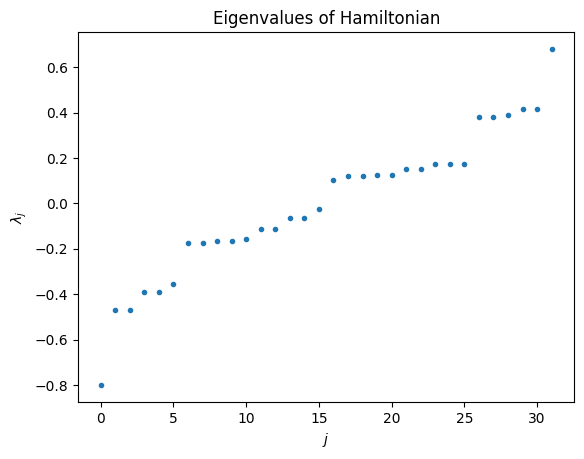

In [8]:
# show spectrum
Hmat = H.as_matrix().toarray()
λ = np.linalg.eigvalsh(Hmat)
plt.plot(λ, ".")
plt.xlabel(r"$j$")
plt.ylabel(r"$\lambda_j$")
plt.title("Eigenvalues of Hamiltonian")
plt.show()

In [9]:
# auxiliary qubit
field_aux = qib.field.Field(qib.field.ParticleType.QUBIT,
                            qib.lattice.IntegerLattice((1,), pbc=False))
qaux = qib.field.Qubit(field_aux, 0)

In [10]:
# block-encoding gate; plays the role of the signal operator
R = qib.BlockEncodingGate(H, qib.operator.BlockEncodingMethod.R)
R.set_auxiliary_qubits([qaux])
R.num_wires

6

In [11]:
R.encoded_operator() is H

True

## Test: compare analytical expression with matrix representation of QSP circuit

In [12]:
# random phases
phi_rnd = rng.standard_normal(size=3)

In [13]:
# upper-left block based on analytic formula
polyH = np.exp(1j*(phi_rnd[0] + phi_rnd[2])) * (2j*np.sin(phi_rnd[1]) * (Hmat @ Hmat) + np.exp(-1j*phi_rnd[1])*np.identity(Hmat.shape[0]))
print("polyH.shape:", polyH.shape)

polyH.shape: (32, 32)


In [14]:
circ_test = qsp_circuit(R, phi_rnd, qaux)

In [15]:
# compare analytical expression with matrix representation of QSP circuit
np.allclose(circ_test.as_matrix([field_hamil, field_aux]).toarray()[:2**L, :2**L], polyH)

True

## QSP for approximating cosine and sine functions

In [16]:
# phase angles from Appendix D.4 of "Grand unification of quantum algorithms"
phi_cos = np.array([
    -1.70932079, -0.05312746,  2.12066859, -0.83307065,
    -0.50074601,  0.40728859,  0.32838472,  0.9142489,
    -2.81320793,  0.40728859, -0.50074601,  2.30852201,
    -1.02092406, -0.05312746,  3.00306819])

In [17]:
# phase angles from Appendix D.4 of "Grand unification of quantum algorithms"
phi_sin = np.array([
    -1.63276817,  0.20550406, -0.84198335,  0.39732059,
    -0.26820613,  2.41324245,  0.04662674, -2.02847501,
     1.11311765,  0.04662674, -0.72835021, -0.26820613,
     0.39732059, -0.84198335,  0.20550406, -0.06197184])

In [18]:
circ_cos = lambda a: qsp_circuit(W(a, qaux), phi_cos, qaux)
circ_sin = lambda a: qsp_circuit(W(a, qaux), phi_sin, qaux)

In [19]:
# |+⟩
ketp = np.array([1, 1])/np.sqrt(2)

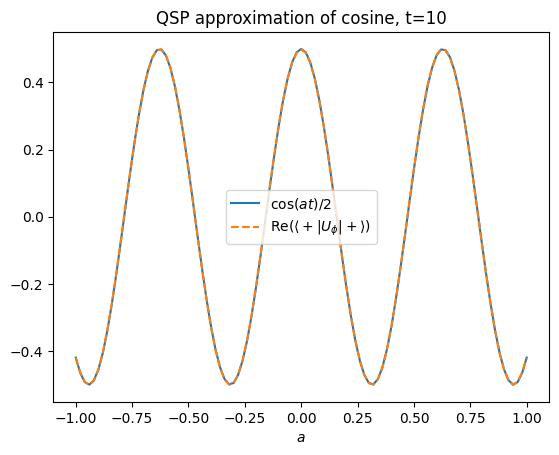

In [20]:
# visualize exact cosine function and QSP approximation;
# reproduces Fig. 23 in "Grand unification of quantum algorithms"
a_list = np.linspace(-1, 1, 101)
plt.plot(a_list, 0.5*np.cos(10*a_list), label=r"$\cos(a t)/2$")
plt.plot(a_list, [np.vdot(ketp, circ_cos(a).as_matrix().toarray() @ ketp).real for a in a_list], "--", label=r"$\mathrm{Re}(\langle+|U_{\phi}|+\rangle)$")
plt.xlabel(r"$a$")
plt.legend()
plt.title("QSP approximation of cosine, t=10")
plt.show()

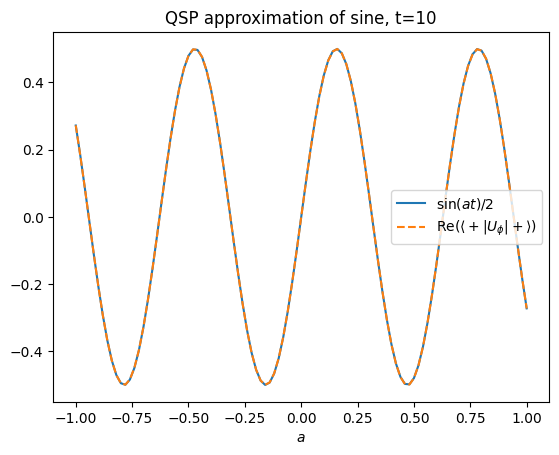

In [21]:
# visualize exact sine function and QSP approximation;
# reproduces Fig. 24 in "Grand unification of quantum algorithms"
a_list = np.linspace(-1, 1, 101)
plt.plot(a_list, 0.5*np.sin(10*a_list), label=r"$\sin(a t)/2$")
plt.plot(a_list, [np.vdot(ketp, circ_sin(a).as_matrix().toarray() @ ketp).real for a in a_list], "--", label=r"$\mathrm{Re}(\langle+|U_{\phi}|+\rangle)$")
plt.xlabel(r"$a$")
plt.legend()
plt.title("QSP approximation of sine, t=10")
plt.show()

## QSP for matrix cosine and sine functions of Hamiltonian

In [22]:
def convert_phase_shifts(d):
    """
    Phase shifts to convert between different QSP representations.
    """
    return np.array([np.pi/4] + (d-1)*[np.pi/2] + [np.pi/4])

In [23]:
circ_hamil_cos = qsp_circuit(R, phi_cos - convert_phase_shifts(len(phi_cos)-1), qaux)
circ_hamil_sin = qsp_circuit(R, phi_sin - convert_phase_shifts(len(phi_sin)-1), qaux)

# include global i**d phase factor
circ_hamil_cos.append_gate(qib.PhaseFactorGate(0.5*np.pi * ((len(phi_cos)-1) % 4), 1).on(qaux))
circ_hamil_sin.append_gate(qib.PhaseFactorGate(0.5*np.pi * ((len(phi_sin)-1) % 4), 1).on(qaux))

# appending and prepending Hadamard gates, corresponds to convention <+|U_φ|+>
circ_hamil_cos.append_gate( qib.HadamardGate(qaux))
circ_hamil_cos.prepend_gate(qib.HadamardGate(qaux))
circ_hamil_sin.append_gate( qib.HadamardGate(qaux))
circ_hamil_sin.prepend_gate(qib.HadamardGate(qaux))

In [24]:
# approximation error of cosine of Hamiltonian
np.linalg.norm(circ_hamil_cos.as_matrix([field_hamil, field_aux]).toarray()[:2**L, :2**L] - 0.5*cosm(10*Hmat), ord=2)

0.0016681632176289314

In [25]:
# approximation error of sine of Hamiltonian
np.linalg.norm(circ_hamil_sin.as_matrix([field_hamil, field_aux]).toarray()[:2**L, :2**L] - 0.5*sinm(10*Hmat), ord=2)

0.0005805884485787741

## QSP for matrix exponential of Hamiltonian, i.e., time evolution operator

In [26]:
# additional auxiliary qubit for combining cosine and sine into exponential
field_aux2 = qib.field.Field(qib.field.ParticleType.QUBIT,
                             qib.lattice.IntegerLattice((1,), pbc=False))
qaux2 = qib.field.Qubit(field_aux2, 0)

In [27]:
# construct circuit for approximating matrix exponential of Hamiltonian,
# see Fig. 17 in "Grand unification of quantum algorithms"
circ_expiHt = qib.Circuit()
circ_expiHt.append_gate(qib.HadamardGate(qaux2))
for gate in circ_hamil_cos.gates:
    # activate control by |0> state
    circ_expiHt.append_gate(qib.ControlledGate(gate, 1, bitpattern=0).set_control(qaux2))
for gate in circ_hamil_sin.gates:
    circ_expiHt.append_gate(qib.ControlledGate(gate, 1).set_control(qaux2))
# -i factor of sine term
circ_expiHt.append_gate(qib.ControlledGate(qib.PhaseFactorGate(-0.5*np.pi, 1).on(qaux), 1).set_control(qaux2))
circ_expiHt.append_gate(qib.HadamardGate(qaux2))

In [28]:
# matrix representation of circuit
circ_expiHt_mat = circ_expiHt.as_matrix([field_hamil, field_aux, field_aux2]).toarray()
print("circ_expiHt_mat.shape:", circ_expiHt_mat.shape)

circ_expiHt_mat.shape: (128, 128)


In [29]:
# approximation error of time evolution operator exp(-i H t) at t = 10
np.linalg.norm(circ_expiHt_mat[:2**L, :2**L] - 0.25*expm(-10j*Hmat), ord=2)

0.000835605876958209

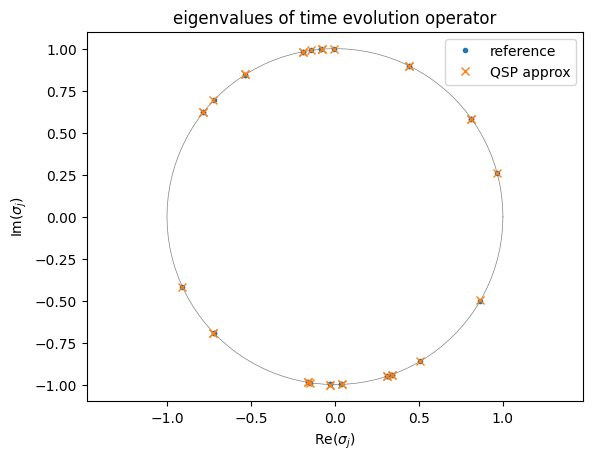

In [30]:
# visualize and compare eigenvalues of time evolution operator
σU_ref = np.linalg.eigvals(expm(-10j*Hmat))
σU = np.linalg.eigvals(circ_expiHt_mat[:2**L, :2**L])
plt.plot([np.cos(2*np.pi*x) for x in np.linspace(0, 1, 101)], [np.sin(2*np.pi*x) for x in np.linspace(0, 1, 101)], color="gray", linewidth=0.5)
plt.plot(σU_ref.real, σU_ref.imag, '.', label="reference")
plt.plot(4*σU.real, 4*σU.imag, 'x', label="QSP approx")
plt.xlabel(r"$\mathrm{Re}(\sigma_j)$")
plt.ylabel(r"$\mathrm{Im}(\sigma_j)$")
plt.axis("equal")
plt.title("eigenvalues of time evolution operator")
plt.legend()
plt.show()